### auto_SAR_Ocean_Contrast \(autonomous Ocean Contrast Estimation for SAR Images\)
**A Python module for estimating the contrast in a SAR image of the ocean surface, relative to clean water pixels.  The code is primarily intended to identify oil slicks, but can be used to identify any radar-dark feature in a scene that is not entirely radar-dark. The contrast ratio is often referred to as the damping ratio in the scientific literature concerning mineral oil slicks.**

Author: Peter Mao, Cathleen E. Jones

Note: This is based on MATLAB code written by Cathleen E. Jones, and has been translated to Python and further optimized.
     
**Cite this code as:**
**[ ]()**

**Cite the algorithm as:**
**[Jones, C. E. (2023). An automated algorithm for calculating the ocean contrast in support of oil spill response. Marine Pollution Bulletin, 191, 114952.](https://www.sciencedirect.com/science/article/pii/S0025326X23003843)**

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Copyright (c) 2023-24 California Institute of Technology (“Caltech”). U.S. Government
sponsorship acknowledged. ALL RIGHTS RESERVED.

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

http://www.apache.org/licenses/LICENSE-2.0

Redistribution and use in source and binary forms, with or without modification, are permitted provided
that the following conditions are met:  
• Redistributions of source code must retain the above copyright notice, this list of conditions and
the following disclaimer.  
• Redistributions in binary form must reproduce the above copyright notice, this list of conditions
and the following disclaimer in the documentation and/or other materials provided with the
distribution.  
• Neither the name of Caltech nor its operating division, the Jet Propulsion Laboratory, nor the
names of its contributors may be used to endorse or promote products derived from this software
without specific prior written permission.

THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS
IS" AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO,
THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR
PURPOSE ARE DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT OWNER OR
CONTRIBUTORS BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL,
EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO,
PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR PROFITS;
OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY,
WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR
OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF
ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.
  

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

In [1]:
wd = "/Volumes/Santa_Barbara/OceanContrastCode_ExampleFiles/GeoTIFF-Sentinel1/GeoTIFF-masked/"
wd = "/Volumes/Santa_Barbara/OceanContrastCode_ExampleFiles/GeoTIFF-Sentinel1/GeoTIFF-uselandmask/test/"
wd = "/Volumes/Santa_Barbara/OceanContrastCode_ExampleFiles/ENVI-UAVSAR/" 
wd = "/Volumes/Santa_Barbara/OceanContrastCode_ExampleFiles/NetCDF-Sentinel1/" 

## HEADER - must run once to import packages

In [2]:
DEBUG = False  # ENABLE DEBUG TO SEE INTERMEDIATE PLOTS

from matplotlib.pyplot import *
import numpy as np
from numpy import pi
from numpy.polynomial.polynomial import polyval
from os import path, makedirs
from os.path import abspath, basename
from glob import glob
from pprint import pp
from datetime import datetime
from netCDF4 import Dataset as ncfile
import yaml, spectral

import OilClassification.io as io
import OilClassification.util as u
from OilClassification import pkl

from osgeo import gdal

versionLabel = 'JPL' + io.get_most_recent_git_tag()
print(versionLabel)

JPL0.21


## Read in the `config.yaml` file
See [`../prototypes/config.yaml`](http://localhost:8888/edit/prototypes/config.yaml) for an example.  The link assumes your jupyter session is on http://localhost:8888.  Edit the link if necessary

In [3]:
wd = path.expanduser(wd)
with open(abspath(path.join(wd, 'config.yaml'))) as fh:
    cfg = yaml.safe_load(fh)
cfgIn   = cfg['input']
cfgProc = cfg['process']
cfgOut  = cfg['output']

DataFormat = cfgIn['format'].upper() # ENVI, GEOTIFF, or NETCDF

if cfgIn['indeg']:
    ang2deg = 1
    ang2rad = pi/180
    angLabel = 'deg'
else:
    ang2deg = 180/pi
    ang2rad = 1
    angLabel = 'rad'

## read file list; get maskfile


In [4]:
filelist = np.sort(glob(path.join(wd, cfgIn['infiles'])))
inputDir = path.dirname(filelist[0])

if cfgIn['uselandmask']:
    maskfile = path.join(inputDir, cfgIn['maskfile'] + '.hdr')
    LandMask = spectral.open_image(maskfile)
    landmask = LandMask.read_band(0).astype(bool)
else:
    landmask = False

In [5]:
jj = 0 # Main loop index variable.

# MAIN LOOP
Loops over each entry of `filelist`.  The `for` is suppressed to allow parts of the loop to be chunked.

## Set up output directories

In [6]:
thisfile = filelist[jj]
print(thisfile)
infile   = path.splitext(path.basename(thisfile))[0]

if DataFormat == 'ENVI':
    hdrfile = path.join(inputDir, thisfile + '.hdr')
    [rootname, product, pol, lineID, fltID, datatake, fltdate] = io.parse_prodname_UAVSAR(thisfile)
    incangfile = path.abspath(path.join(inputDir, rootname + cfgIn['incangsuffix']))
if DataFormat in ['GEOTIFF','NETCDF']:
    product = None

try: # cfgOut['outdir'] might be a python statement or a string
    outdir  = path.join(wd, eval(cfgOut['outdir']))
except:
    outdir  = path.join(wd, cfgOut['outdir'])
makedirs(outdir, exist_ok=True)

/Volumes/Santa_Barbara/OceanContrastCode_ExampleFiles/NetCDF-Sentinel1/S1A_ESA_2023_06_06_00_16_12_0739325772_091.83W_19.51N_VV_C_nrcs_level2.nc


### load the main data (`NRCS`) and incidence angle files
generate maps with and without the land mask

* `nrcs_db` could be radar cross section or some other derived parameter (from rcs)

In [7]:
if DataFormat == 'ENVI':
    NRCS  = spectral.open_image(hdrfile)
    IncAng = spectral.open_image(incangfile + '.hdr')

    nrcs_db  = np.ma.masked_invalid(NRCS.read_band(0))
    incang = np.ma.masked_invalid(IncAng.read_band(0))
elif DataFormat == 'GEOTIFF':
    DataSet = gdal.Open(thisfile)
    dataset = DataSet.ReadAsArray().astype(np.double)

    nrcs_db  = np.ma.masked_invalid(dataset[0])
    incang = np.ma.masked_invalid(dataset[1])
elif DataFormat == 'NETCDF':
    with ncfile(thisfile) as ds:
        nrcs_db    = ds['sigma'][:].astype(np.double)
        incang   = ds['incid'][:].astype(np.double)
        landmask = ds['mask'][:] > 0
        ULx = np.double(ds.ul_outer_lon); ULy = np.double(ds.ul_outer_lat)
        URx = np.double(ds.ur_outer_lon); URy = np.double(ds.ur_outer_lat)
        LLx = np.double(ds.ll_outer_lon); LLy = np.double(ds.ll_outer_lat)
        LRx = np.double(ds.lr_outer_lon); LRy = np.double(ds.lr_outer_lat)
        T = ((ULx + URx) + 1j*(ULy + URy))/2
        B = ((LLx + LRx) + 1j*(LLy + LRy))/2
        L = ((ULx + LLx) + 1j*(ULy + LLy))/2
        R = ((URx + LRx) + 1j*(URy + LRy))/2

        img_rot = np.angle((T-B)*(-1j))
        lr_flip = bool(abs(img_rot - np.angle(R-L)) > pi/2)
        print("image rotation: %f rad; flip: %d"%(img_rot, lr_flip))

# default config assumption is that nrcs_db is in dB.
if 'indb' in cfgIn and not cfgIn['indb']:
    #nrcs_db.mask |= nrcs_db.data <= 0
    nrcs_db = 10 * np.ma.log10(nrcs_db)

if DEBUG:
    figure()
    hist(nrcs_db[~nrcs_db.mask],np.linspace(-100,0,1000));
    yscale('log');

# mask out unphysically low values
nrcs_db.mask |= nrcs_db < -50

if DEBUG:
    figure()
    clims = np.percentile(nrcs_db.data[~nrcs_db.mask] , [5, 95])
    imshow(nrcs_db, vmin=clims[0], vmax=clims[1], cmap='gray', origin='lower')
    title('nrcs_db - full')
    colorbar()

# mask out land in `nrcs_db`
nrcs_db.mask |= landmask

if DEBUG:
    figure()
    clims = np.percentile(nrcs_db.data[~nrcs_db.mask], [5, 95])
    imshow(nrcs_db, vmin=clims[0], vmax=clims[1], cmap='gray', origin='lower')
    title('nrcs_db - landmasked')
    colorbar()

image rotation: 0.198815 rad; flip: 0


### Generate the angular bins
`incang` is in radians, but angle limits are specified in degrees.

In [8]:
# mask out land in `incang`
incang.mask |= landmask

# generate the angular bins
angmin = np.amin(incang)*ang2deg
angmax = np.amax(incang)*ang2deg
angminb = angmin
if cfgProc['setinclolim']:
    angminb = max(cfgProc['inclolim'], angminb)
angmaxb = angmax
if cfgProc['setinchilim']:
    angmaxb = min(cfgProc['inchilim'], angmaxb)
nAngBins    = max(1, round(angmaxb - angminb))
angbinedges = np.linspace(angminb,angmaxb,nAngBins + 1)
angbinedges = angbinedges.astype(np.double) / ang2deg
# balance the bins to equalize populations
inchist,_ = np.histogram(incang[~incang.mask], angbinedges)
inccumulative = np.concatenate(([0], np.cumsum(inchist)))
angbinedges = np.interp(np.linspace(0, inccumulative[-1], inccumulative.size),
                        inccumulative, angbinedges)

angmap      = np.digitize(incang, angbinedges)

if DEBUG:
    figure(figsize=(16,9),dpi=110)
    imshow(angmap, origin='lower')
    title('Histogram bin for each pixel (1:%d)\n0 and %d are off-scale.'%(nAngBins,nAngBins+1))
    colorbar()

### Find the clean water in the image within each angular bin

Histogramming of the reflected intensity vs incidence angle happens inside `id_pix_as_cleanwater`.

* The smoothing algorithm needs some work -- matlab's `smooth` (not yet adopted here) is visibly more appealing, but may get noisy near the endpoints of the histogram

In [9]:
# set up for inner loop
cleanmask  = np.zeros(nrcs_db.data.shape).astype(bool)
nosolution = np.zeros(nAngBins).astype(bool)

angPopulation = np.histogram(incang, angbinedges)[0]
avgHistPop = np.sum(~incang.mask) / nAngBins

# try to make the xrange of the figures the same.
xlimits = np.percentile(nrcs_db.data[~nrcs_db.mask], [1, 99])

lastval = None;
for ii in np.r_[1:nAngBins + 1]:
    thisnrcs = nrcs_db.copy()
    thisnrcs.mask |= (angmap != ii)

    # skip pixels with low-population angle bins
    if np.sum((~thisnrcs.mask).astype(int)) < 0.001 * avgHistPop:
        nrcs_db.mask |= (angmap == ii)
        print("skipping bin %d for low population"%ii)
        continue

    clean, nosolution[ii-1], lastval = u.id_pix_as_cleanwater(thisnrcs, lastval, makefigs=DEBUG)
    if DEBUG:
        if lastval is not None:
            title('Incidence angles [%.1f, %.1f) deg (bin %d, $\sigma_{cw}$=%.1f)'%
                  (angbinedges[ii-1]*ang2deg, angbinedges[ii]*ang2deg, ii-1, lastval))
        else:
            title('Incidence angles [%.1f, %.1f) deg (bin %d, $\sigma_{cw}$=None)'%
                  (angbinedges[ii-1]*ang2deg, angbinedges[ii]*ang2deg, ii-1))

        # extend xlim if needed
        xlimits[0] = min(xlimits[0],xlim()[0])
        xlimits[1] = max(xlimits[1],xlim()[1])
        xlim(xlimits)

    cleanmask |= clean
    if nosolution[ii-1]:
        print("(angle bin %d)."%ii)
    if not cfgProc['bootstrap']:
        lastval = None

if not np.any(cleanmask):
    print('Failed: No clean water pixels identified in file %s.'%thisfile)
    #continue

outsideanglims = np.zeros(incang.shape).astype(bool)
if cfgProc['setinclolim']:
    outsideanglims |= (incang < cfgProc['inclolim'] / ang2deg)
if cfgProc['setinchilim']:
    outsideanglims |= (incang > cfgProc['inchilim'] / ang2deg)

if DEBUG:
    figure()
    imshow(cleanmask, origin='lower')
    title('clean mask')

<>:25: SyntaxWarning: invalid escape sequence '\s'
<>:28: SyntaxWarning: invalid escape sequence '\s'
<>:25: SyntaxWarning: invalid escape sequence '\s'
<>:28: SyntaxWarning: invalid escape sequence '\s'
/var/folders/b1/mn1wwlrs3jlghwkcmxfvdb2nc6km7l/T/ipykernel_17511/3508224725.py:25: SyntaxWarning: invalid escape sequence '\s'
  title('Incidence angles [%.1f, %.1f) deg (bin %d, $\sigma_{cw}$=%.1f)'%
/var/folders/b1/mn1wwlrs3jlghwkcmxfvdb2nc6km7l/T/ipykernel_17511/3508224725.py:28: SyntaxWarning: invalid escape sequence '\s'
  title('Incidence angles [%.1f, %.1f) deg (bin %d, $\sigma_{cw}$=None)'%


### Fit nrcs_db vs. incang restricting data to clean water
`contrast` holds data to be pickled.  Unlike matlab's `*.mat` files, python's pickle files
can only hold a single variable.
    

In [10]:
status, wfit, fittype, nfitbins = u.fit_xy_from_AOImask(incang, nrcs_db, cleanmask, makefigs=DEBUG,
                                                        Xlabel= f'incidence angle [{angLabel}]',
                                                        Ylabel= 'nrcs_db signal [dB]',
                                                        Title = infile)
cleanwaterfit = polyval(incang, wfit)
if DEBUG:
    figure()
    imshow(cleanwaterfit, origin='lower')
    title('clean water signal [dB]')
    colorbar()

### Collect files over which to calculate damping ratio

In [11]:
if DataFormat == 'ENVI':
    FilesToProcess = []
    for ftype in cfgProc['filetype']:
        namestr = f'*{lineID}*{fltID}*{datatake}*{ftype}'
        FilesToProcess = list(np.concatenate((FilesToProcess, glob(path.join(inputDir,namestr)))))
    for pattern in cfgProc['exclude']:
        FilesToProcess = [f for f in FilesToProcess if pattern not in f]
    cfgOut['interleave'] = NRCS.metadata['interleave']
    cfgOut['metadata']   = NRCS.metadata
elif DataFormat in ['GEOTIFF','NETCDF']:
    FilesToProcess = [thisfile]
    if cfgOut['format'].upper() == 'ENVI':
        if cfgIn['uselandmask']:
            cfgOut['interleave'] = LandMask.metadata['interleave']
            cfgOut['metadata']   = LandMask.metadata
        else:
            cfgOut['interleave'] = "bip" # default if not specified
            cfgOut['metadata']   = ()

### Calculate contrast for each valid filetype

* Assign `nrcs_lin` according to data format
* Generate figures
* Write results to corresponding outfile.

/Users/cjones/tools/OilClassification/OilClassification/util.py:301: RuntimeWarning: divide by zero encountered in divide
  ithreshold = np.argwhere(yy[imax:]/gauss > ratio)[0][0] + imax
/Users/cjones/tools/OilClassification/OilClassification/util.py:301: RuntimeWarning: overflow encountered in divide
  ithreshold = np.argwhere(yy[imax:]/gauss > ratio)[0][0] + imax
/Users/cjones/tools/OilClassification/OilClassification/util.py:301: RuntimeWarning: invalid value encountered in divide
  ithreshold = np.argwhere(yy[imax:]/gauss > ratio)[0][0] + imax


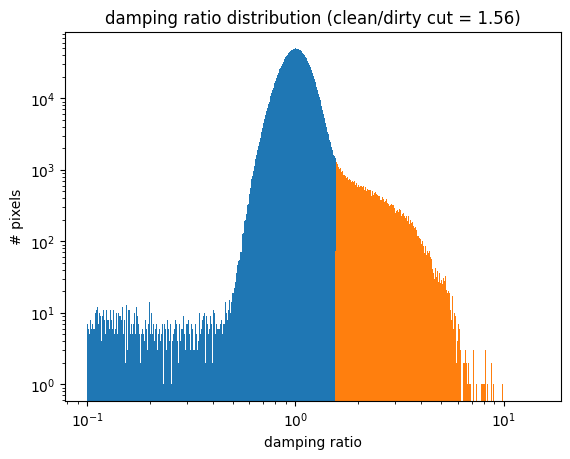

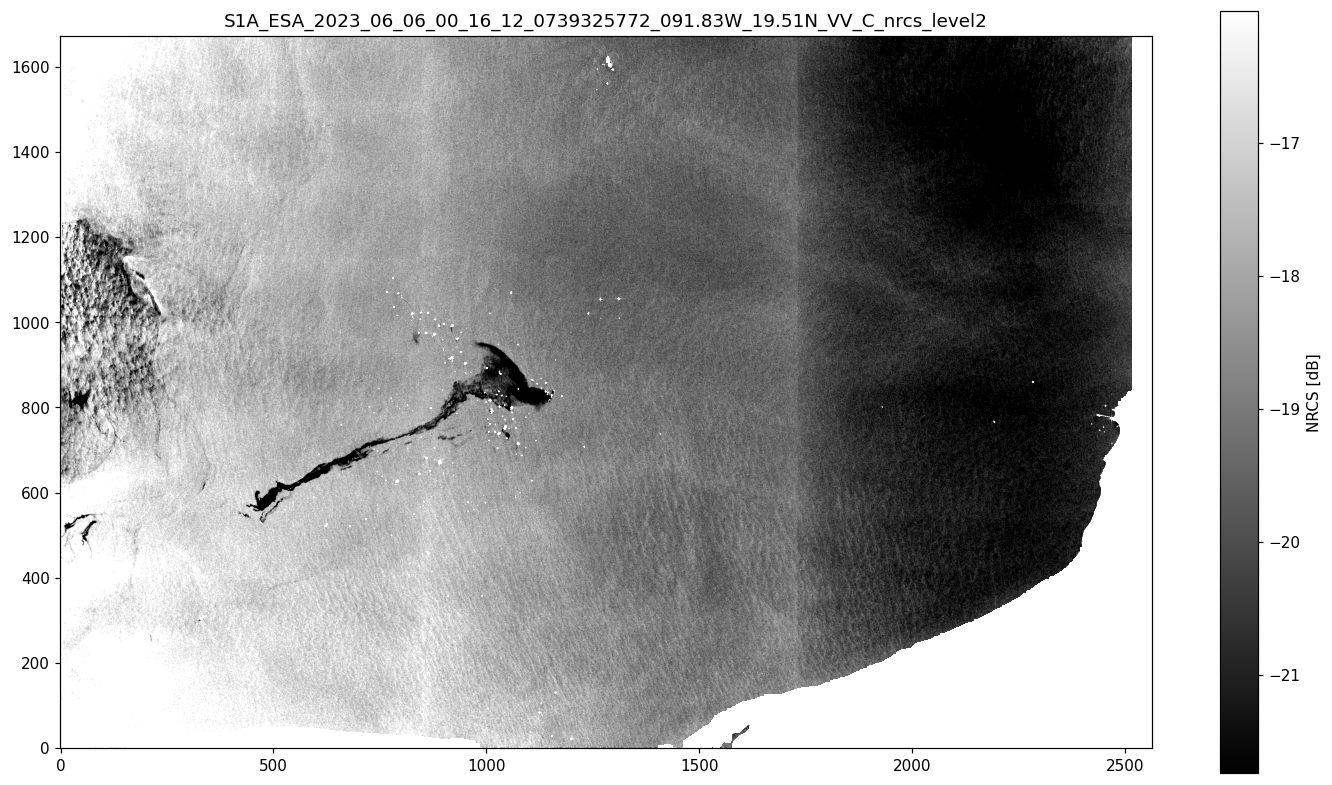

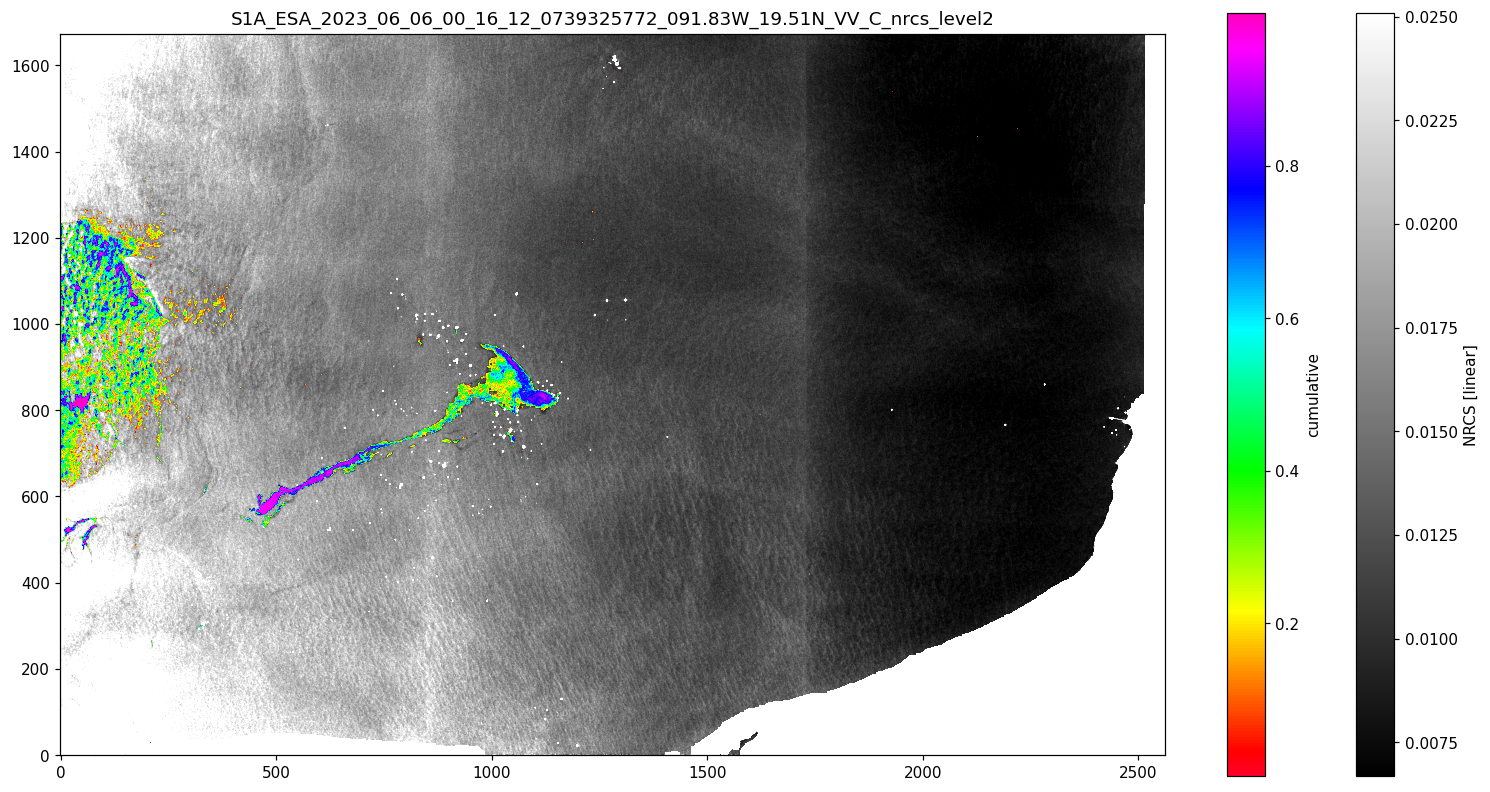

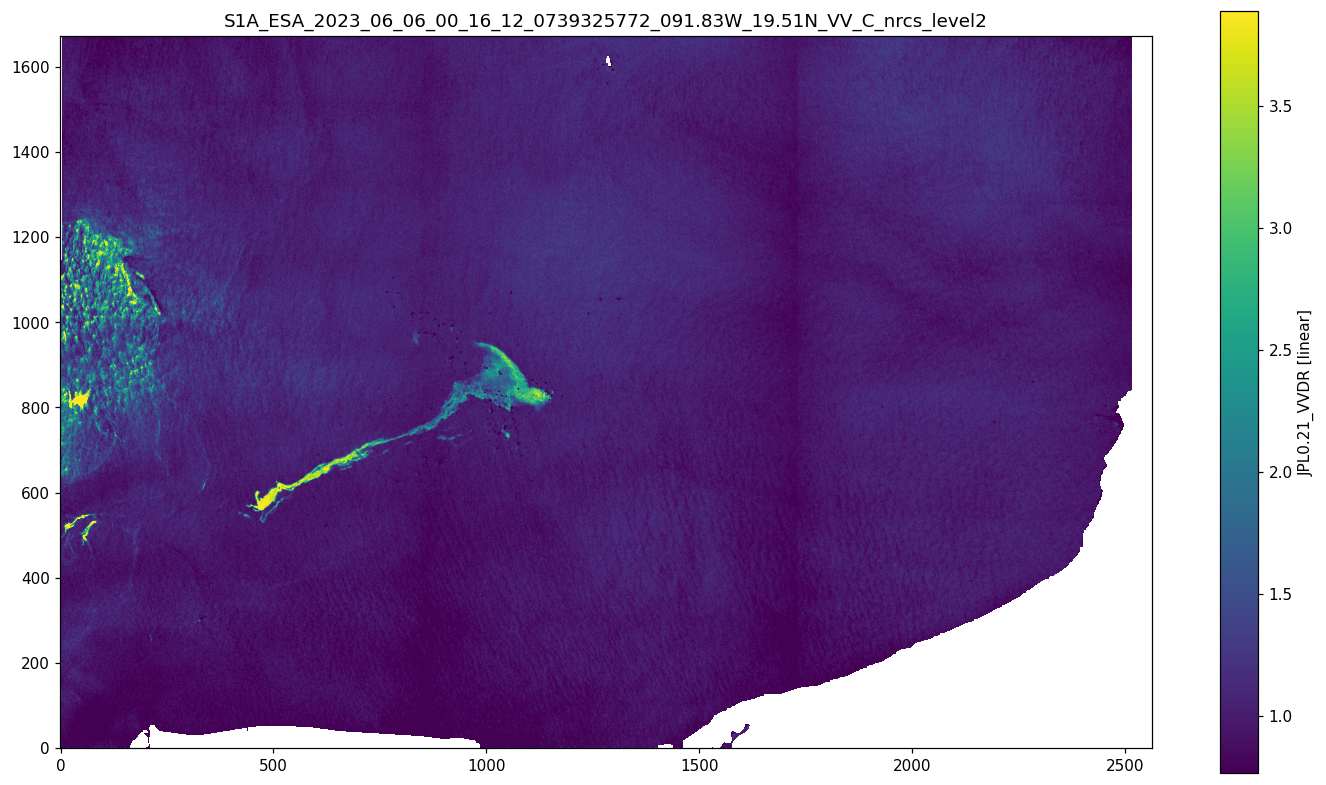

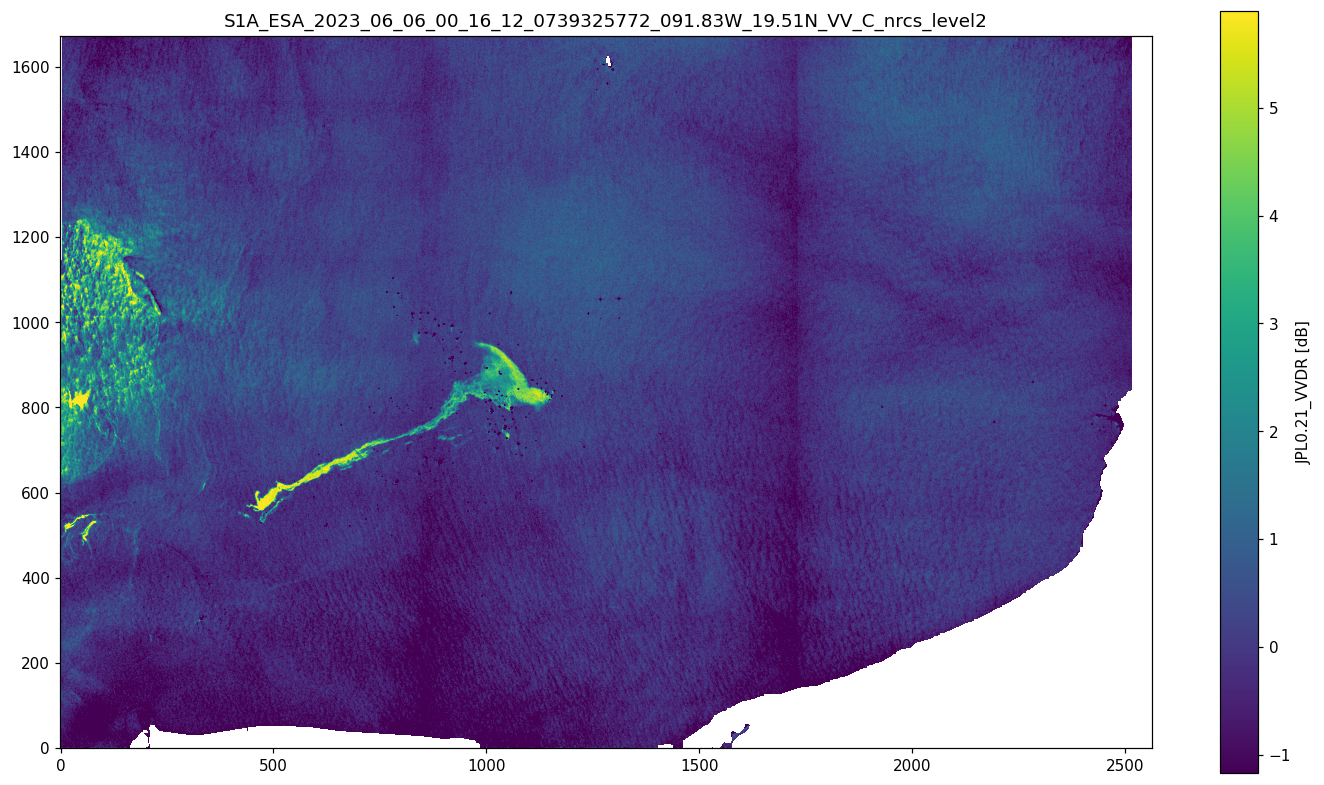

In [12]:
for fileToProcess in FilesToProcess:
    (file_basename, suffix) = path.splitext(basename(fileToProcess))
    if DataFormat == 'ENVI':
        cfgOut['ID'] = f'{versionLabel}_DR'
        thisNRCS = spectral.open_image(fileToProcess + '.hdr')
        nrcs_lin = np.ma.masked_invalid(thisNRCS.read_band(0))
    elif DataFormat in ['GEOTIFF','NETCDF']:
        if DataFormat == 'NETCDF':
            with ncfile(fileToProcess) as ds:
                cfgOut['ID'] = f'{versionLabel}_{ds.getncattr("polarization")}DR'
        else: # GEOTIFF
            cfgOut['ID'] = f'{versionLabel}_{cfgProc["polarization"]}DR'
        nrcs_lin = (np.power(10, nrcs_db * 0.1)) # nrcs_lin is nrcs_db in linear units

    status, pfit, fittype, nfitbins = u.fit_xy_from_AOImask(incang, nrcs_lin, cleanmask, makefigs=DEBUG,
                                                            Xlabel = f'incidence angle [{angLabel}]',
                                                            Ylabel = 'mean signal',
                                                            Title  = file_basename)
    waterfit = polyval(incang, pfit)

    nrcs_lin.mask |= landmask
    dampratio = waterfit / nrcs_lin
    dampratio.mask |= outsideanglims

    DR_minDirty = u.dumb_sigma(dampratio, ratio=100)
    dirtywater = np.ma.masked_less(dampratio, DR_minDirty)
    cumulative = np.ma.masked_array(np.argsort(np.ma.argsort(dirtywater,axis=None),axis=None).reshape(nrcs_lin.shape))/np.sum(~dirtywater.mask);
    cumulative.mask = dirtywater.mask
    cumulative = u.ma_remove_small(cumulative,area=2)
    cumu_expanded = u.ma_expand(cumulative,2.9)

    figure()
    bins = np.logspace(-1,np.log10(np.amax(dampratio)),1000)
    hist(dampratio[~dampratio.mask],bins)
    hist(dirtywater[~dirtywater.mask],bins)
    title('damping ratio distribution (clean/dirty cut = %.2f)'%DR_minDirty)
    xlabel('damping ratio')
    ylabel('# pixels')
    yscale('log'); xscale('log')
    savefig(abspath(path.join(outdir, f'{file_basename}_{cfgOut["ID"]}_DRHist.png')))

    figure(figsize=(16,9),dpi=110) # db signal amplitude
    clims = np.percentile(nrcs_db.data[~nrcs_db.mask], [5,95])
    imshow(nrcs_db, vmin=clims[0], vmax=clims[1], cmap='gray', origin='lower')
    title(file_basename)
    colorbar(label='NRCS [dB]')
    savefig(abspath(path.join(outdir, f'{file_basename}_{versionLabel}_NRCS_dB.png')))

    figure(figsize=(16,9),dpi=110) # linear signal amplitude with cumulative overlay
    clims = np.percentile(nrcs_lin.data[~nrcs_lin.mask], [5,95])
    imshow(nrcs_lin, vmin=clims[0], vmax=clims[1], cmap='gray', origin='lower')
    colorbar(label='NRCS [linear]',fraction=.05)
    title(file_basename)
    imshow(cumu_expanded,cmap='gist_rainbow', origin='lower')
    colorbar(label='cumulative', fraction=.05)
    imshow(nrcs_lin, alpha=0, origin='lower') # transparent overlay
    savefig(abspath(path.join(outdir, f'{file_basename}_{versionLabel}_NRCS_linear+cumul.png')))

    figure(figsize=(16,9),dpi=110) # linear damping ratio
    clims = np.percentile(dampratio.data[~dampratio.mask], [5,99.9])
    imshow(dampratio, vmin=clims[0], vmax=clims[1], origin='lower')
    colorbar(label=f'{cfgOut["ID"]} [linear]')
    title(file_basename)
    savefig(abspath(path.join(outdir, f'{file_basename}_{cfgOut["ID"]}_linear.png')))

    figure(figsize=(16,9),dpi=110) # logarithmic damping ratio (dB)
    imshow((10*np.ma.log10(dampratio)), vmin=10*np.log10(clims[0]), vmax=10*np.log10(clims[1]), origin='lower')
    colorbar(label=f'{cfgOut["ID"]} [dB]')
    title(file_basename)
    savefig(abspath(path.join(outdir, f'{file_basename}_{cfgOut["ID"]}_dB.png')))

    # output format is specified by cfgOut['format'] \in {envi, geotiff, netcdf}
    datadict = {'contrast_ratio': {'data': dampratio,
                                   'long_name': 'Contrast ratio'},
                'cumulative'    : {'data': cumulative,
                                   'long_name': 'Cumulative distribution of the contrast ratio'}}
    io.writedata(datadict, fileToProcess, outdir, cfgOut)

In [13]:
if jj+1 < len(filelist):
    jj += 1
    print("Return to first block below loop index initialization to run next case.")
else:
    print("No more data to process (jj = %d)"%jj)

No more data to process (jj = 0)
